2024-07-26 15:47:43.301538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 15:47:43.301675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 15:47:43.468335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Medium
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Hard
Loading data from: ../input/socofing/SOCOFing/Real


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 763s 1s/step - accuracy: 0.0028 - loss: 6.5963 - val_accuracy: 0.0056 - val_loss: 6.3736 - learning_rate: 1.0000e-04
Epoch 2/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - accuracy: 0.0150 - loss: 6.1877 - val_accuracy: 0.0773 - val_loss: 5.4341 - learning_rate: 1.0000e-04
Epoch 3/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - accuracy: 0.0793 - loss: 5.2265 - val_accuracy: 0.3350 - val_loss: 3.8961 - learning_rate: 1.0000e-04
Epoch 4/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.2693 - loss: 3.6738 - val_accuracy: 0.6909 - val_loss: 2.1613 - learning_rate: 1.0000e-04
Epoch 5/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 712s 1s/step - accuracy: 0.5316 - loss: 2.2096 - val_accuracy: 0.8782 - val_loss: 1.0668 - learning_rate: 1.0000e-04
Epoch 6/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 729s 1s/step - accuracy: 0.7261 - loss: 1.2937 - val_accuracy: 0.9388 - val_loss: 0.6605 - learning_rate: 1.0000e-04
Epoch 7/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - acc

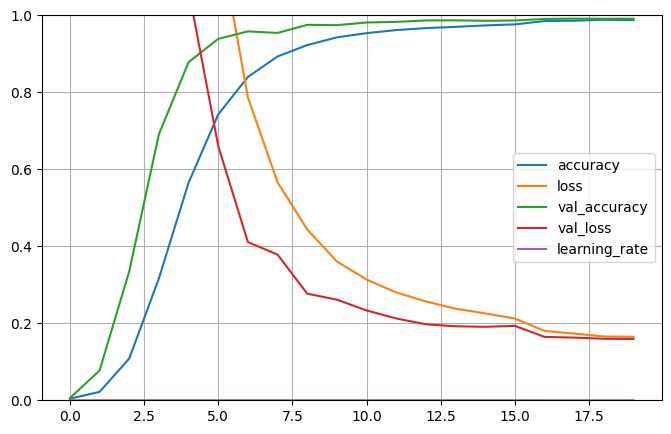

Id recognition accuracy: 99.75000023841858 %
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step
Information confirm! Fingerprint matches: person Id 156


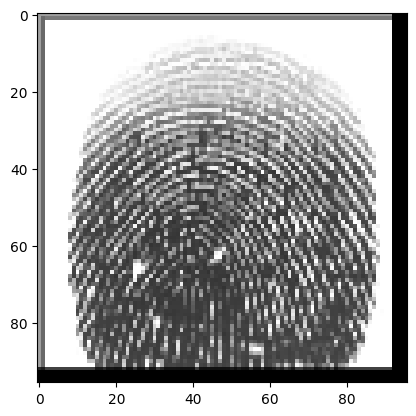

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

img_size = 96

def load_data(path, train=True):
    print("Loading data from:", path)
    data = []
    for img in os.listdir(path):
        try:
            imgname, ext = os.path.splitext(img)
            ID, etc = imgname.split('__')
            ID = int(ID) - 1  # to_categorical encodes starting from 0

            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            if img_array is None:
                print(f"Warning: Skipping image {img} as it could not be read.")
                continue

            img_resize = cv2.resize(img_array, (img_size, img_size))
            data.append([ID, img_resize])
        except Exception as e:
            print(f"Error processing image {img}: {e}")
            continue
    return data

Altered_path = "../input/socofing/SOCOFing/Altered/Altered-"
Real_path = "../input/socofing/SOCOFing/Real"

Easy_data = load_data(Altered_path + 'Easy', train=True)
Medium_data = load_data(Altered_path + 'Medium', train=True)
Hard_data = load_data(Altered_path + 'Hard', train=True)
Real_data = load_data(Real_path, train=False)

Altered_data = Easy_data + Medium_data + Hard_data  # Use list concatenation instead of np.concatenate
del Easy_data, Medium_data, Hard_data  # Free some memory

X_Altered, y_SubjectID_Altered = [], []

for SubjectID, feature in Altered_data:
    X_Altered.append(feature)
    y_SubjectID_Altered.append(SubjectID)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0  # Normalize to [0, 1]
y_SubjectID_Altered = to_categorical(y_SubjectID_Altered, num_classes=600)  # 600 persons in total

X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val = train_test_split(
    X_Altered, y_SubjectID_Altered, test_size=0.2, random_state=2)

X_test, y_SubjectID_test = [], []

for SubjectID, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)

del Altered_data, Real_data, y_SubjectID_Altered  # Free some memory again

nets = 1
model = [0] * nets
final_Dense_units = [600]
model_name = ['SubjectID_Mod']

for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

    # Save the model summary to a text file
    with open('summary.txt', 'w') as f:
        model[i].summary(print_fn=lambda x: f.write(x + '\n'))

    # Save the model architecture image
    plot_model(model[i], show_shapes=True, to_file='model0.png')

    history = [0] * nets

CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64

for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])
    ]

history[0] = model[0].fit(X_SubjectID_train, y_SubjectID_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_SubjectID_val, y_SubjectID_val),
                          verbose=1, callbacks=CallBack[0])

model[0].save("sID.h5")

# Plot training history
pd.DataFrame(history[0].history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluate the model
testing_acc_Id = model[0].evaluate(X_test, y_SubjectID_test, verbose=0)
print("Id recognition accuracy:", testing_acc_Id[1] * 100, "%")

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0] - 1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])

if Id_pred == Id_real:
    print("Information confirm! Fingerprint matches: person Id", Id_pred)
else:
    print("Oops! Prediction is wrong!")


**TensorFlow backend.**